In [26]:
%matplotlib inline
%load_ext dotenv
%dotenv env.sh
%run source/utils.py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import os.path as osp
from skimage import util, morphology, transform, exposure, filters, feature, segmentation
from scipy import ndimage as ndi
from cytokit import io as ck_io
from cytokit.function import data as ck_data
from cytokit import config as ck_config
from cytokit.function import data as ck_data
from cytokit.image.ops import describe
from cytokit.ops import tile_generator, cytometry
plt.gray()
None

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


<Figure size 432x288 with 0 Axes>

In [200]:
#exp_name, ti, z = '02.5mT-np-0uMsta-XY01-1', 1, 5
exp_name, ti, z = '02.5mT-np-0uMsta-XY01-1', 2, 5
#exp_name, ti, z = '10.0mT-wp-0uMsta-XY03-3', 23, 7
#exp_name, ti, z = '10.0mT-wp-0uMsta-XY03-3', 23, 0

In [201]:
df = pd.read_csv('experiments.csv')
df = df[df['name'] == exp_name]
assert len(df) == 1
r = df.iloc[0]
r

name       02.5mT-np-0uMsta-XY01-1
conf               experiment.yaml
dir         025mioTcells-nopeptide
grid                          XY01
n_ch                             4
n_tiles                         33
n_z                              9
cond              02.5mT-np-0uMsta
rep                              1
z_pitch                        200
Name: 3, dtype: object

In [202]:
raw_dir = osp.join(os.environ['EXP_GROUP_RAW_DIR'], r['dir'], r['grid'])
raw_dir

'/lab/data/spheroid/20190719-co-culture/raw/025mioTcells-nopeptide/XY01'

In [203]:
config = get_config(r)

In [204]:
config

{'analysis': [{'aggregate_cytometry_statistics': {'mode': 'best_z_plane'}}, {'cellprofiler_quantification': {'export_csv': True, 'export_db': True}}], 'environment': {'path_formats': "get_default_path_formats('1_XY01_{tile:05d}_Z{z:03d}_CH{channel:d}.tif')"}, 'date': '2019-07-19 00:00:00', 'processor': {'best_focus': {'channel': 'HOECHST'}, 'args': {'run_deconvolution': False, 'gpus': [0, 1], 'run_cytometry': True, 'run_best_focus': True, 'run_spectral_unmixing': False}, 'tile_generator': {'raw_file_type': 'keyence_mixed'}, 'cytometry': {'quantification_params': {'morphology_features': False, 'nucleus_intensity': True, 'cell_graph': False}, 'target_shape': [1008, 1344], 'nuclei_channel_name': 'HOECHST'}, 'deconvolution': {'channels': ['HOECHST', 'ICYTE', 'SYTOX'], 'n_iter': 10, 'scale_factor': 0.75}}, 'operator': [{'extract': {'channels': ['proc_HOECHST', 'proc_ICYTE', 'proc_SYTOX', 'proc_BF', 'cyto_cell_boundary'], 'name': 'best_z_segm'}}, {'montage': {'extract_name': 'best_z_segm', '

In [205]:
tile = tile_generator.CytokitTileGenerator(config, raw_dir, 0, tile_index=ti).run()
describe(tile)

{'bytes': 49766400,
 'max': 65535,
 'mean': 15167.131362405156,
 'min': 0,
 'shape': (1, 9, 4, 720, 960),
 'type': 'uint16'}

In [206]:
def prepare(img):
    assert img.dtype in [np.uint8, np.uint16]
    img = exposure.rescale_intensity(img, in_range=str(img.dtype), out_range=np.uint8).astype(np.uint8)
    img = filters.median(img, selem=morphology.disk(3))
    img = util.img_as_float(img)
    img = filters.gaussian(img, sigma=1)
    return img

In [207]:
img_nuc = tile[0, z, config.channel_names.index('HOECHST')]
describe(img_nuc)

{'bytes': 1382400,
 'max': 65535,
 'mean': 3355.605392071759,
 'min': 0,
 'shape': (720, 960),
 'type': 'uint16'}

In [208]:
img = prepare(img_nuc)
describe(img)

{'bytes': 5529600,
 'max': 0.9953894865726884,
 'mean': 0.04877693646996767,
 'min': 1.5708706375963423e-06,
 'shape': (720, 960),
 'type': 'float64'}

In [209]:
import math
def num_sigmas(max_sigma, min_sigma, sigma_ratio):
    return int(math.log(float(max_sigma) / min_sigma, sigma_ratio)) + 1
num_sigmas(min_sigma=5, max_sigma=12, sigma_ratio=1.2)

5

(199, 3)


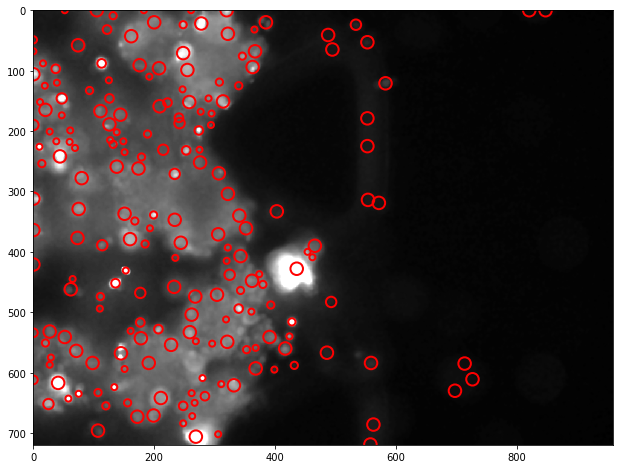

In [210]:
blobs = feature.blob_dog(img, min_sigma=5, max_sigma=12, sigma_ratio=1.2, threshold=.005, overlap=.75)
print(blobs.shape)
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.imshow(img.clip(0, .3))
for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

### Cytometer Testing

In [165]:
%run source/cell_cytometer

In [166]:
cytometer = CellCytometer(config)

In [167]:
img_seg = cytometer.segment(img_nuc[np.newaxis])

In [168]:
describe(img_seg)

{'bytes': 5529600,
 'max': 595,
 'mean': 18.063628472222224,
 'min': 0,
 'shape': (1, 4, 720, 960),
 'type': 'uint16'}

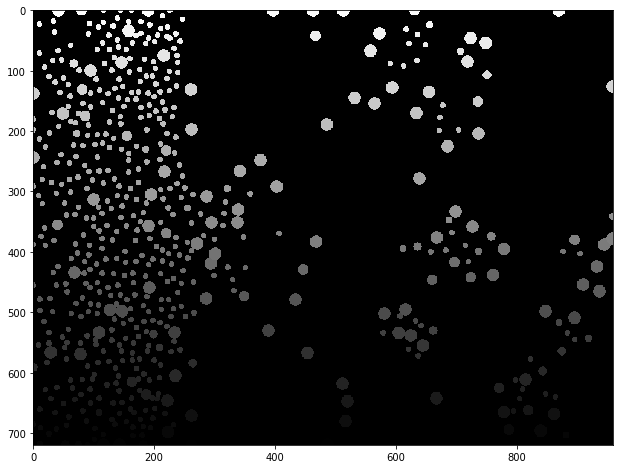

In [173]:
plt.imshow(img_seg[0, 0])
plt.gcf().set_size_inches(12, 8)